In [1]:
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/lcx/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import json

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [4]:
# import os
# os.environ["NLTK_DATA"] = "/Users/lcx/nltk_data"

In [114]:
import random

In [3]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

## 1. preprocess the text

In [4]:
work_dir = "/Users/lcx/Documents/machine_learning/projects/text_topic_analysis/"

In [6]:
df = pd.read_csv(work_dir + "data/top_k_conf_paper_with_abstract_filter.csv", index_col=False)

In [7]:
df.head(2)

,conf_abbr,conference_name,year,name,author_info,article_link,abstract
0,cvpr,CVPR (Computer Vision),2019,A Theory of Fermat Paths for Non-Line-of-Sight...,"Shumian Xin, Carnegie Mellon University|; et a...",semanticscholar.org/paper/5809decf0a47a8a6be5c...,We present a novel theory of Fermat paths of l...
1,cvpr,CVPR (Computer Vision),2018,Taskonomy: Disentangling Task Transfer Learning,"Amir R. Zamir, Stanford University|; et al.|Al...",https://www.semanticscholar.org/paper/2fe2cfd9...,"Do visual tasks have a relationship, or are th..."


In [56]:
df["abstract_process"] = df["abstract"].tolist()

In [57]:
df["word_count"] = df["abstract"].apply(lambda x: len(x.split()))

In [58]:
df["truncated"] = df["abstract"].apply(lambda x: x.endswith("...."))

In [60]:
df[df["truncated"]==True]

,conf_abbr,conference_name,year,name,author_info,article_link,abstract,abstract_process,word_count,truncated
10,cvpr,CVPR (Computer Vision),2009,Single Image Haze Removal Using Dark Channel P...,"Kaiming He, The Chinese University of Hong Kon...",https://www.semanticscholar.org/paper/db0fd1d8...,"In this paper, we propose a simple but effecti...","In this paper, we propose a simple but effecti...",34,True


In [61]:
df_1 = df[df["word_count"] > 30]
print(df_1.shape)

(194, 10)


In [79]:
# remove @; remove many whitespace; remove '; remove ?; remove ..+
df_1["abstract_process"] = df_1["abstract_process"].apply(lambda x: re.sub("(\s*@\s*\s?)|(\s+)|(\')|(\?)|(\.\.+)", " ", x))
# remove hyper link
df_1["abstract_process"] = df_1["abstract_process"].apply(lambda x: re.sub("\w+:\/\/\S+", " ", x))

/Users/lcx/anaconda3/envs/ML_py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/lcx/anaconda3/envs/ML_py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [81]:
#Converting into lowercase
df_1["abstract_process"] = df_1["abstract_process"].str.lower()

/Users/lcx/anaconda3/envs/ML_py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [82]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(df_1["abstract_process"] ))

print(data_words[:1])

[['we', 'present', 'novel', 'theory', 'of', 'fermat', 'paths', 'of', 'light', 'between', 'known', 'visible', 'scene', 'and', 'an', 'unknown', 'object', 'not', 'in', 'the', 'line', 'of', 'sight', 'of', 'transient', 'camera', 'these', 'light', 'paths', 'either', 'obey', 'specular', 'reflection', 'or', 'are', 'reflected', 'by', 'the', 'object', 'boundary', 'and', 'hence', 'encode', 'the', 'shape', 'of', 'the', 'hidden', 'object', 'we', 'prove', 'that', 'fermat', 'paths', 'correspond', 'to', 'discontinuities', 'in', 'the', 'transient', 'measurements', 'we', 'then', 'derive', 'novel', 'constraint', 'that', 'relates', 'the', 'spatial', 'derivatives', 'of', 'the', 'path', 'lengths', 'at', 'these', 'discontinuities', 'to', 'the', 'surface', 'normal', 'based', 'on', 'this', 'theory', 'we', 'present', 'an', 'algorithm', 'called', 'fermat', 'flow', 'to', 'estimate', 'the', 'shape', 'of', 'the', 'non', 'line', 'of', 'sight', 'object', 'our', 'method', 'allows', 'for', 'the', 'first', 'time', 'accu

In [83]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=10.0) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=10.0)  

# Export the trained model
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [85]:
# see bigram example
print(bigram_mod[bigram_mod[data_words[0]]])

['we_present', 'novel', 'theory', 'of', 'fermat', 'paths', 'of', 'light', 'between', 'known', 'visible', 'scene', 'and', 'an', 'unknown', 'object', 'not', 'in', 'the', 'line', 'of', 'sight', 'of', 'transient', 'camera', 'these', 'light', 'paths', 'either', 'obey', 'specular', 'reflection', 'or', 'are', 'reflected', 'by', 'the', 'object', 'boundary', 'and', 'hence', 'encode', 'the', 'shape', 'of', 'the', 'hidden', 'object', 'we', 'prove', 'that', 'fermat', 'paths', 'correspond', 'to', 'discontinuities', 'in', 'the', 'transient', 'measurements', 'we', 'then', 'derive', 'novel', 'constraint', 'that', 'relates', 'the', 'spatial', 'derivatives', 'of', 'the', 'path', 'lengths', 'at', 'these', 'discontinuities', 'to', 'the', 'surface', 'normal', 'based_on', 'this', 'theory', 'we_present', 'an', 'algorithm', 'called', 'fermat', 'flow', 'to', 'estimate', 'the', 'shape', 'of', 'the', 'non', 'line', 'of', 'sight', 'object', 'our_method', 'allows', 'for', 'the', 'first', 'time', 'accurate', 'shape

In [84]:
# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['we_present_novel', 'theory', 'of', 'fermat', 'paths', 'of', 'light', 'between', 'known', 'visible', 'scene', 'and', 'an', 'unknown', 'object', 'not', 'in', 'the', 'line', 'of', 'sight', 'of', 'transient', 'camera', 'these', 'light', 'paths', 'either', 'obey', 'specular', 'reflection', 'or', 'are', 'reflected', 'by', 'the', 'object', 'boundary', 'and', 'hence', 'encode', 'the', 'shape', 'of', 'the', 'hidden', 'object', 'we', 'prove', 'that', 'fermat', 'paths', 'correspond', 'to', 'discontinuities', 'in', 'the', 'transient', 'measurements', 'we_then', 'derive', 'novel', 'constraint', 'that', 'relates', 'the', 'spatial', 'derivatives', 'of', 'the', 'path', 'lengths', 'at', 'these', 'discontinuities', 'to', 'the', 'surface', 'normal', 'based_on', 'this', 'theory', 'we_present', 'an', 'algorithm', 'called', 'fermat', 'flow', 'to', 'estimate', 'the', 'shape', 'of', 'the', 'non', 'line', 'of', 'sight', 'object', 'our_method', 'allows', 'for', 'the', 'first', 'time', 'accurate', 'shape', 're

In [108]:
print(sorted(stop_words))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in', 'into', 'is', 'isn', "isn't", 'it', "it's", 'its', 'itself', 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 'paper', 're', 's', 'same', 'shan', "shan't", 'she', "she's", 'should', "should've", 'shouldn', "shouldn't", 'so'

In [109]:
stop_words.extend(["paper", "using", "use", "show", "problem", "good"])
print(sorted(stop_words))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'good', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in', 'into', 'is', 'isn', "isn't", 'it', "it's", 'its', 'itself', 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 'paper', 'paper', 'problem', 're', 's', 'same', 'shan', "shan't", 'she', "she's", 'should', "should've", 

In [121]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# indeed, one can also use nltk for lemmatization
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [146]:
print(data_words_bigrams[0])

['present_novel', 'theory', 'fermat', 'paths', 'light', 'known', 'visible', 'scene', 'unknown', 'object', 'line', 'sight', 'transient', 'camera', 'light', 'paths', 'either', 'obey', 'specular', 'reflection', 'reflected', 'object', 'boundary', 'hence', 'encode', 'shape', 'hidden', 'object', 'prove', 'fermat', 'paths', 'correspond', 'discontinuities', 'transient', 'measurements', 'derive', 'novel', 'constraint', 'relates', 'spatial', 'derivatives', 'path', 'lengths', 'discontinuities', 'surface', 'normal', 'based', 'theory', 'present', 'algorithm', 'called', 'fermat', 'flow', 'estimate', 'shape', 'non', 'line', 'sight', 'object', 'method', 'allows', 'first', 'time', 'accurate', 'shape', 'recovery', 'complex', 'objects', 'ranging', 'diffuse', 'specular', 'hidden', 'around', 'corner', 'well', 'hidden', 'behind', 'diffuser', 'finally', 'approach', 'agnostic', 'particular', 'technology', 'used', 'transient', 'imaging', 'demonstrate', 'mm', 'scale', 'shape', 'recovery', 'pico', 'second', 'sca

In [147]:
doc_test = nlp(" ".join(data_words_bigrams[0]))

In [153]:
print(doc_test[0])
doc_test[0].pos_

present_novel


'PROPN'

In [122]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# https://spacy.io/usage/processing-pipelines
# we disable parser (DependencyParser) and ner (EntityRecognizer)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['theory', 'fermat', 'path', 'light', 'know', 'visible', 'scene', 'unknown', 'object', 'line', 'sight', 'camera', 'light', 'path', 'obey', 'specular', 'reflection', 'reflect', 'object', 'hence', 'encode', 'shape', 'hide', 'object', 'prove', 'fermat', 'path', 'correspond', 'discontinuity', 'transient', 'measurement', 'derive', 'novel', 'constraint', 'relate', 'spatial', 'derivative', 'path', 'length', 'discontinuity', 'surface', 'normal', 'base', 'theory', 'present', 'call', 'fermat', 'flow', 'estimate', 'shape', 'non', 'line', 'sight', 'object', 'method', 'allow', 'first', 'time', 'accurate', 'shape', 'recovery', 'complex', 'object', 'range', 'diffuse', 'hide', 'corner', 'well', 'hide', 'finally', 'approach', 'agnostic', 'particular', 'technology', 'use', 'transient', 'imaging', 'demonstrate', 'scale', 'shape', 'recovery', 'pico', 'second', 'scale', 'transient', 'spad', 'ultrafast', 'laser', 'scale', 'reconstruction', 'second', 'scale', 'transient', 'believe', 'work', 'significant', '

In [123]:
print(data_lemmatized[0])

['theory', 'fermat', 'path', 'light', 'know', 'visible', 'scene', 'unknown', 'object', 'line', 'sight', 'camera', 'light', 'path', 'obey', 'specular', 'reflection', 'reflect', 'object', 'hence', 'encode', 'shape', 'hide', 'object', 'prove', 'fermat', 'path', 'correspond', 'discontinuity', 'transient', 'measurement', 'derive', 'novel', 'constraint', 'relate', 'spatial', 'derivative', 'path', 'length', 'discontinuity', 'surface', 'normal', 'base', 'theory', 'present', 'call', 'fermat', 'flow', 'estimate', 'shape', 'non', 'line', 'sight', 'object', 'method', 'allow', 'first', 'time', 'accurate', 'shape', 'recovery', 'complex', 'object', 'range', 'diffuse', 'hide', 'corner', 'well', 'hide', 'finally', 'approach', 'agnostic', 'particular', 'technology', 'use', 'transient', 'imaging', 'demonstrate', 'scale', 'shape', 'recovery', 'pico', 'second', 'scale', 'transient', 'spad', 'ultrafast', 'laser', 'scale', 'reconstruction', 'second', 'scale', 'transient', 'believe', 'work', 'significant', 'a

In [124]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency 
# Bag-of_words actually (token_id, token_count)
corpus = [id2word.doc2bow(text) for text in texts]

In [125]:
# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 1), (20, 1), (21, 3), (22, 1), (23, 1), (24, 1), (25, 1), (26, 3), (27, 2), (28, 1), (29, 1), (30, 1), (31, 2), (32, 3), (33, 1), (34, 1), (35, 2), (36, 1), (37, 1), (38, 1), (39, 5), (40, 1), (41, 4), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 2), (48, 1), (49, 1), (50, 1), (51, 4), (52, 1), (53, 2), (54, 4), (55, 3), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 2), (64, 1), (65, 4), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1)]]


### 2. Build a LDA model

In [126]:
shuffle_corpus = corpus[:]

random.seed(100)
random.shuffle(shuffle_corpus)
print(len(shuffle_corpus))
print(shuffle_corpus[0])

194
[(9, 2), (11, 1), (20, 2), (23, 1), (30, 1), (34, 1), (47, 1), (52, 4), (53, 1), (56, 1), (68, 2), (73, 3), (80, 1), (92, 1), (93, 3), (95, 1), (107, 1), (129, 5), (144, 1), (167, 1), (181, 4), (193, 1), (214, 1), (227, 1), (234, 1), (247, 2), (260, 1), (283, 1), (309, 1), (322, 4), (324, 2), (328, 3), (344, 1), (358, 2), (375, 1), (419, 1), (439, 1), (466, 1), (478, 1), (511, 2), (545, 1), (581, 1), (585, 1), (613, 1), (627, 2), (632, 1), (652, 2), (691, 1), (720, 5), (749, 1), (750, 1), (812, 1), (814, 2), (820, 1), (824, 1), (826, 1), (903, 1), (922, 1), (1003, 1), (1101, 2), (1286, 1), (1328, 1), (1385, 1), (1387, 1), (1388, 1), (1389, 3), (1390, 1), (1391, 7), (1392, 1), (1393, 1), (1394, 1), (1395, 1), (1396, 2), (1397, 2), (1398, 1), (1399, 1), (1400, 1), (1401, 1), (1402, 1), (1403, 1)]


In [127]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           minimum_probability=0.01,
                                           passes=80,
                                           alpha='auto')

In [131]:
lda_model.show_topics(num_topics=5, num_words=10, formatted=False)

[(0,
  [('knowledge', 0.012588227),
   ('base', 0.010133054),
   ('model', 0.009621711),
   ('approach', 0.009280493),
   ('language', 0.007123701),
   ('plan', 0.006885302),
   ('new', 0.0067893523),
   ('network', 0.0065997415),
   ('word', 0.0065628192),
   ('use', 0.006014075)]),
 (1,
  [('query', 0.009137168),
   ('method', 0.009103267),
   ('algorithm', 0.0068310946),
   ('application', 0.0064967657),
   ('datum', 0.006102414),
   ('technique', 0.005835306),
   ('time', 0.0057410877),
   ('present', 0.005699568),
   ('base', 0.0055117253),
   ('search', 0.0051603722)]),
 (2,
  [('model', 0.01962271),
   ('query', 0.010897659),
   ('object', 0.01068641),
   ('result', 0.006888239),
   ('approach', 0.006708304),
   ('learn', 0.0065922798),
   ('image', 0.006275225),
   ('system', 0.0059673763),
   ('database', 0.005963746),
   ('present', 0.0057252096)]),
 (3,
  [('system', 0.009374242),
   ('method', 0.0090711685),
   ('model', 0.008258617),
   ('performance', 0.008210165),
   ('b

In [129]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.499536089527743

Coherence Score:  0.213516888466489


In [143]:
lda_model.show_topics()

[(0,
  '0.013*"knowledge" + 0.010*"base" + 0.010*"model" + 0.009*"approach" + 0.007*"language" + 0.007*"plan" + 0.007*"new" + 0.007*"network" + 0.007*"word" + 0.006*"use"'),
 (1,
  '0.009*"query" + 0.009*"method" + 0.007*"algorithm" + 0.006*"application" + 0.006*"datum" + 0.006*"technique" + 0.006*"time" + 0.006*"present" + 0.006*"base" + 0.005*"search"'),
 (2,
  '0.020*"model" + 0.011*"query" + 0.011*"object" + 0.007*"result" + 0.007*"approach" + 0.007*"learn" + 0.006*"image" + 0.006*"system" + 0.006*"database" + 0.006*"present"'),
 (3,
  '0.009*"system" + 0.009*"method" + 0.008*"model" + 0.008*"performance" + 0.008*"base" + 0.007*"datum" + 0.007*"result" + 0.006*"good" + 0.006*"index" + 0.006*"use"'),
 (4,
  '0.009*"model" + 0.008*"learn" + 0.008*"task" + 0.008*"retrieval" + 0.007*"search" + 0.007*"image" + 0.007*"system" + 0.006*"document" + 0.006*"user" + 0.006*"datum"')]

### 3. visulize the topic words

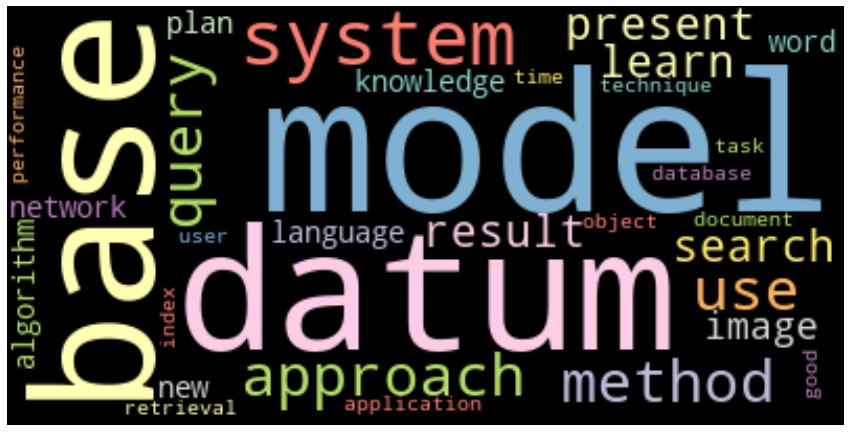

In [130]:
from wordcloud import WordCloud

from wordcloud import WordCloud, ImageColorGenerator
text = " ".join(str(each) for each in lda_model.show_topics())
wordcloud = WordCloud(max_words=2000,colormap='Set3', background_color="black").generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='Bilinear')
plt.axis("off")
plt.figure(1,figsize=(12, 12))
plt.show()

In [142]:
print(df_1.iloc[100,:]["abstract_process"])

recently, lakemeyer and levesque proposed a logic of only-knowing which precisely captures three forms of nonmonotonic reasoning: moore s autoepistemic logic, konolige s variant based on moderately grounded expansions, and reiter s default logic. defaults have a uniform representation under all three interpretations in the new logic. moreover, the logic itself is monotonic, that is, nonmonotonic reasoning is cast in terms of validity in the classical sense. while lakemeyer and levesque gave a model-theoretic account of their logic, a proof-theoretic characterization remained open. this paper fills that gap for the propositional subset: a sound and complete axiom system in the new logic for all three varieties of default reasoning. we also present formal derivations for some examples of default reasoning. finally we present evidence that it is unlikely that a complete axiom system exists in the first-order case, even when restricted to the simplest forms of default reasoning.


In [141]:
lda_model.get_document_topics(corpus[100])

[(1, 0.24038851), (3, 0.7577537)]